In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

torch.cuda.is_available()

device = torch.device("cuda:0")

In [2]:
noisy_imgs_1, noisy_imgs_2 = torch.load('../data/train_data.pkl') #pairs of images with different noises each time

In [3]:
val_noisy_imgs, clean_imgs = torch.load('../data/val_data.pkl')
val_noisy_imgs = val_noisy_imgs.to(device)
clean_imgs = clean_imgs.to(device)

In [4]:
noisy_imgs_1, noisy_imgs_2 = ((noisy_imgs_1/255.0) - 0.5).to(device), ((noisy_imgs_2/255.0) - 0.5).to(device)

In [5]:
"""
This file contains all necessary functions and classes to implement the autoencoder described in the paper 
"Noise2Noise: Learning Image Restoration without Clean Data"
Link: https://arxiv.org/abs/1803.04189
"""

import torch
from torch import nn

"""
Describes an "encoding block" in the autoencoder; it's composed of a 3x3 convolutional layer, followed by either
a leaky relu or linear activation layer, and a 2x2 maxpool layer
"""

class EncodingBlock(nn.Module):
    
    def __init__(self, n_in, n_out):
        super().__init__()
        
        self.conv = nn.Conv2d(n_in, n_out, kernel_size = 3, padding = 'same', padding_mode = 'zeros')
        self.pool = nn.MaxPool2d(kernel_size = 2)
        self.activation = nn.LeakyReLU(0.1)
    
    def forward(self,x):
        x = self.conv(x)
        x = self.activation(x)
        x = self.pool(x)
        
        return x
    
"""
Describes an "decoding block" in the autoencoder; it's composed of a 3x3 convolutional layer, followed by either
a leaky relu or linear activation layer, and a 2x2 upsample layer
"""
class DecodingBlock(nn.Module):
    
    def __init__(self, n_in, n_out):
        super().__init__()
        
        self.conv = nn.Conv2d(n_in, n_out, kernel_size = 3, padding = 'same', padding_mode = 'zeros') 
        self.up = nn.Upsample(scale_factor = 2,mode = 'nearest')
        self.activation = nn.LeakyReLU(0.1)
    
    def forward(self, x):
        x = self.conv(x)
        x = self.activation(x)
        x = self.up(x)
        return x
    
"""
Implements the autoencoder
"""
class Noise2Noise(nn.Module):
    
    def __init__(self, n = 3, m = 3):    
        super().__init__()
        self.conv_init = nn.Conv2d(n, 48, kernel_size = 3, padding = 'same', padding_mode = 'zeros')
        
        #### ENCODING BLOCKS
        self.encoding1 = EncodingBlock(48, 48)
        self.encoding2 = EncodingBlock(48, 48)
        self.encoding3 = EncodingBlock(48, 48)
        self.encoding4 = EncodingBlock(48, 48)
        self.encoding5 = EncodingBlock(48, 48)
        
        #### DECODING BLOCKS
        self.decoding1 = DecodingBlock(48,48)
        self.conv_decoding1 = nn.Conv2d(96, 96, kernel_size = 3, padding = 'same', padding_mode = 'zeros')
        self.decoding2 = DecodingBlock(96,96)
        self.conv_decoding2 = nn.Conv2d(144, 96, kernel_size = 3, padding = 'same', padding_mode = 'zeros')
        self.decoding3 = DecodingBlock(96,96)
        self.conv_decoding3 = nn.Conv2d(144, 96, kernel_size = 3, padding = 'same')
        self.decoding4 = DecodingBlock(96,96)
        self.conv_decoding4 = nn.Conv2d(144, 96, kernel_size = 3, padding = 'same')
        self.decoding5 = DecodingBlock(96,96)
        
        #### Last layers
        self.conv1 = nn.Conv2d(96 + n, 64, kernel_size = 3, padding = 'same', padding_mode = 'zeros')
        self.conv2 = nn.Conv2d(64, 32, kernel_size = 3, padding = 'same', padding_mode = 'zeros')
        self.conv3 = nn.Conv2d(32, m, kernel_size = 3, padding = 'same', padding_mode = 'zeros')
        
    def forward(self, x):
        input_ = x.detach().clone().to(device)
        n = m = 3
        x = self.conv_init(x).to(device) #enc_conv0
        x = nn.LeakyReLU(0.1)(x)
        #### ENCODING PHASE
        pool1 = self.encoding1(x) #pool1
        pool2 = self.encoding2(pool1) #pool2
        pool3 = self.encoding3(pool2) #pool3
        pool4 = self.encoding3(pool3) #pool4
        pool5 = self.encoding3(pool4) #pool5
        
        
        #### DECODING PHASE
        upsample5 = self.decoding1(pool5)
        concat5 = torch.cat([upsample5,pool4], dim = 1)
        dec_conv5a = self.conv_decoding1(concat5)
        dec_conv5a = nn.LeakyReLU(0.1)(dec_conv5a)
        
        upsample4 = self.decoding2(dec_conv5a)
        concat4 = torch.cat([upsample4,pool3], dim = 1)
        dec_conv4a = self.conv_decoding2(concat4)
        dec_conv4a = nn.LeakyReLU(0.1)(dec_conv4a)
        
        upsample3 = self.decoding2(dec_conv4a)
        concat3 = torch.cat([upsample3,pool2], dim = 1)
        dec_conv3a = self.conv_decoding3(concat3)
        dec_conv3a = nn.LeakyReLU(0.1)(dec_conv3a)
        
        upsample2 = self.decoding2(dec_conv3a)
        concat2 = torch.cat([upsample2,pool1], dim = 1)
        dec_conv2a = self.conv_decoding4(concat2)
        dec_conv2a = nn.LeakyReLU(0.1)(dec_conv2a)
        
        
        upsample1 = self.decoding2(dec_conv2a)
        concat1 = torch.cat([upsample1,input_], dim = 1)
        
        
        #### Last phase
        r = self.conv1(concat1)
        r = nn.LeakyReLU(0.1)(r)
        
        r = self.conv2(r)
        r = nn.LeakyReLU(0.1)(r)
        
        r = self.conv3(r)
        return r

In [6]:
noisy_imgs_1 = noisy_imgs_1[:40000]
noisy_imgs_2 = noisy_imgs_2[:40000]

In [7]:
model = Noise2Noise()

model.to(device)

Noise2Noise(
  (conv_init): Conv2d(3, 48, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (encoding1): EncodingBlock(
    (conv): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (activation): LeakyReLU(negative_slope=0.1)
  )
  (encoding2): EncodingBlock(
    (conv): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (activation): LeakyReLU(negative_slope=0.1)
  )
  (encoding3): EncodingBlock(
    (conv): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (activation): LeakyReLU(negative_slope=0.1)
  )
  (encoding4): EncodingBlock(
    (conv): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [8]:
from torch import optim
import time

In [9]:
loss = nn.L1Loss()
epochs = 50
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.99), eps=1e-08, weight_decay=0)  
N = noisy_imgs_1.size(0)
batch_size = 32

for e in range(epochs):
    t = time.time()
    for index in range(0, N, batch_size):
        optimizer.zero_grad()
        train_data_minibatch = noisy_imgs_1[index:(index+batch_size)]
        train_target_minibatch = noisy_imgs_2[index:(index+batch_size)]
        loss(model(train_data_minibatch), train_target_minibatch).backward()
        optimizer.step()
    print(e)
    print("epoch time : " + str(time.time() - t))

0
epoch time : 18.50593638420105
1
epoch time : 15.216459512710571
2
epoch time : 15.447007417678833
3
epoch time : 15.004262685775757
4
epoch time : 15.083642482757568
5
epoch time : 14.933263540267944
6
epoch time : 14.897072315216064
7
epoch time : 14.868399620056152
8
epoch time : 14.86610722541809
9
epoch time : 14.740073442459106
10
epoch time : 15.151643991470337
11
epoch time : 14.89572787284851
12
epoch time : 15.148243427276611
13
epoch time : 14.888705015182495
14
epoch time : 15.129295349121094
15
epoch time : 14.75307035446167
16
epoch time : 15.113922595977783
17
epoch time : 15.158744096755981
18
epoch time : 15.39096736907959
19
epoch time : 14.732218027114868
20
epoch time : 15.01472282409668
21
epoch time : 14.985953330993652
22
epoch time : 15.008532762527466
23
epoch time : 14.927825689315796
24
epoch time : 14.953169107437134
25
epoch time : 14.845593452453613
26
epoch time : 15.009360790252686
27
epoch time : 14.764366865158081
28
epoch time : 15.044063568115234
2

In [10]:
output = ((model(val_noisy_imgs[:10]/255 - 0.5)))
output = torch.clamp((output + 0.5)*255, min = 0, max = 255).int()

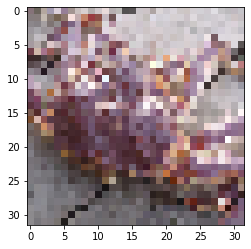

In [11]:
plt.imshow(  val_noisy_imgs[0].cpu().detach().permute(1, 2, 0))

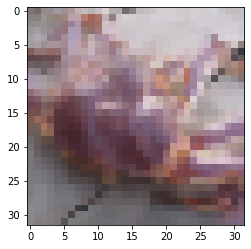

In [12]:
plt.imshow(  output[0].cpu().detach().permute(1, 2, 0))

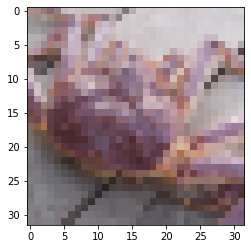

In [13]:
plt.imshow( clean_imgs[0].cpu().detach().permute(1, 2, 0) )